# Chinese Calligraphy Classifier
A Chinese calligraphy classifier built using fast.ai.

## Motivation
As an international student studying in China, I’ve always been fascinated by the diversity of Chinese culture and history. Calligraphy (書) is considered as one of the four ancient Chinese arts, along with stringed musical instruments (琴), the board game “Go” (棋), and painting (畫). Calligraphy has also contributed to the development of many forms of art in China, such as ornate paperweights, ink stones, and seal carving.

There are multiple styles of calligraphy, which mainly belong to different dynasties. Each of them has its way of shaping and arranging the character. For this project, I picked four styles:
- Seal Script (篆書 zhuanshu)
- Cursive Script (草書 caoshu)
- Clerical Script (隸書 lishu)
- Standard Script (楷書 kaishu)

If you are interested, you can read more about these different styles [here](https://en.wikipedia.org/wiki/Chinese_script_styles).

## Setup
Before we start, let's first import the necessary libraries

In [19]:
# Import the libraries
import os

from fastai.vision import *
from fastai.widgets import *

In [3]:
# Get the working directory path
path = "../input"
path

'../input'

## Loading and Preparing the Data
We can import, split, and transform the data using fast.ai’s powerful `ImageDataBunch` object.

In [4]:
# Set a random seed number for the sake of reproducibility
np.random.seed(42)

# Load and prepare the data
data = ImageDataBunch.from_folder(
    path,
    valid_pct=0.2,
    ds_tfms=get_transforms(do_flip=False),
    size=224,
    num_workers=4    
)

data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
kaishu,kaishu,kaishu,kaishu,kaishu
Path: ../input;

Valid: LabelList (400 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
zhuanshu,kaishu,caoshu,lishu,caoshu
Path: ../input;

Test: None

Note that we split the data into training and validation set with an 80:20 ratio. The images are also resized to 224 pixels, which is usually a good value for image recognition tasks. 

In [5]:
# View the classes and length of data in each sets
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['caoshu', 'kaishu', 'lishu', 'zhuanshu'], 4, 1600, 400)

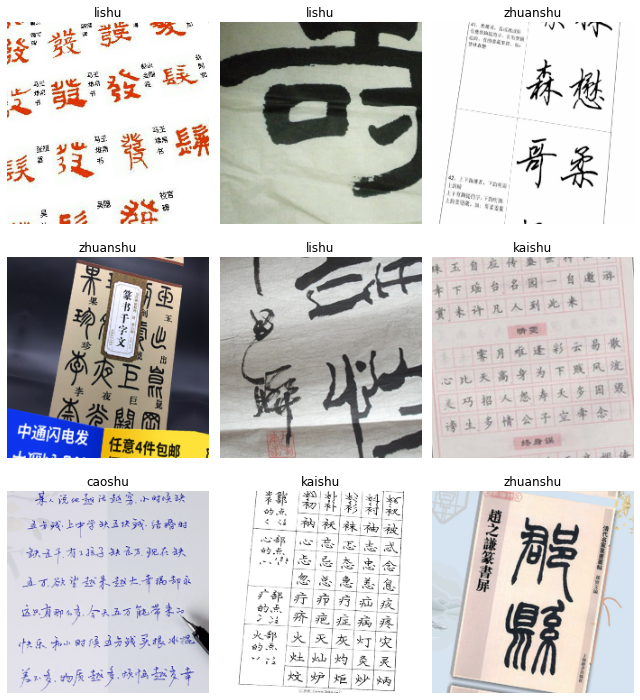

In [6]:
# Take a look at some of the images
data.show_batch(rows=3, figsize=(9,10))

As we can see above, our dataset is rather ‘dirty’. Some of the images are not well-aligned and not properly cropped. But let’s quickly build the model and see how it performs.

## Building the Model
We will be applying transfer learning and use ResNet-50 as our model.

In [7]:
# Download the model along with the pre-trained weights
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir='/tmp/models')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [8]:
# Train the layers using the fit_one_cycle method
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.466915,0.927739,0.737500,01:12
1,1.075304,0.637498,0.790000,01:11
2,0.820588,0.574865,0.822500,01:10


In [9]:
# Save the model
learn.save("stage-1")

## Tuning the Model
By default, the model’s initial layers are frozen to prevent modifying the pre-trained weights. Let’s try unfreezing all the layers and train our model again, hopefully, we can improve the accuracy.

In [10]:
# Unfreeze all the layers
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


To find the perfect learning rate, we can use the `lr_find` and `recorder.plot` methods to create the learning rate plot.

Min numerical gradient: 9.12E-07
Min loss divided by 10: 5.25E-06


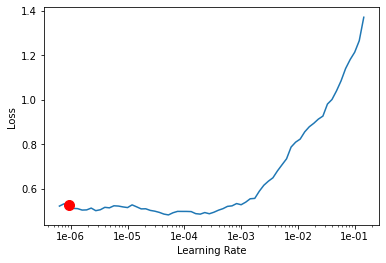

In [11]:
# Create the learning rate plot
learn.recorder.plot(suggestion=True)

The red dot on the graph indicates the point where the gradient is the steepest.

In [12]:
# Get the corresponding learning rate
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

9.120108393559096e-07

In [34]:
# Train the model for another 2 epochs
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.484713,0.273136,0.885609,00:54
1,0.491012,0.287252,0.878229,00:54


In [14]:
# Save the tuned model
learn.save("stage-2")

## Cleaning the Data
fast.ai also provides a nice functionality for cleaning your data using Jupyter widgets. The `ImageCleaner` class displays images for relabeling or deletion. 

In [15]:
# Load the saved model
learn.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
kaishu,kaishu,kaishu,kaishu,kaishu
Path: ../input;

Valid: LabelList (400 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
zhuanshu,kaishu,caoshu,lishu,caoshu
Path: ../input;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

We need use the `DatasetFormatter().from_toplosses` method to get the suggested indices for misclassified images.

In [16]:
# Cleaning the images
ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, "/tmp")

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

The results of the cleaning are saved as `cleaned.csv` which can now be used to load in the data.

In [22]:
# Load the data from the CSV file
df = pd.read_csv("/tmp/cleaned.csv", header="infer")

db = ImageList.from_df(df, "/tmp").\
               split_by_rand_pct(0.2).\
               label_from_df().\
               transform(get_transforms(), size=224).\
               databunch(bs=8)
          
db.normalize(imagenet_stats)

/opt/conda/lib/python3.7/site-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


ImageDataBunch;

Train: LabelList (1085 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
kaishu,kaishu,kaishu,kaishu,kaishu
Path: /tmp;

Valid: LabelList (271 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
caoshu,lishu,lishu,kaishu,lishu
Path: /tmp;

Test: None

In [23]:
# View the classes and length of data in each sets
db.classes, db.c, len(db.train_ds), len(db.valid_ds)

(['caoshu', 'kaishu', 'lishu', 'zhuanshu'], 4, 1085, 271)

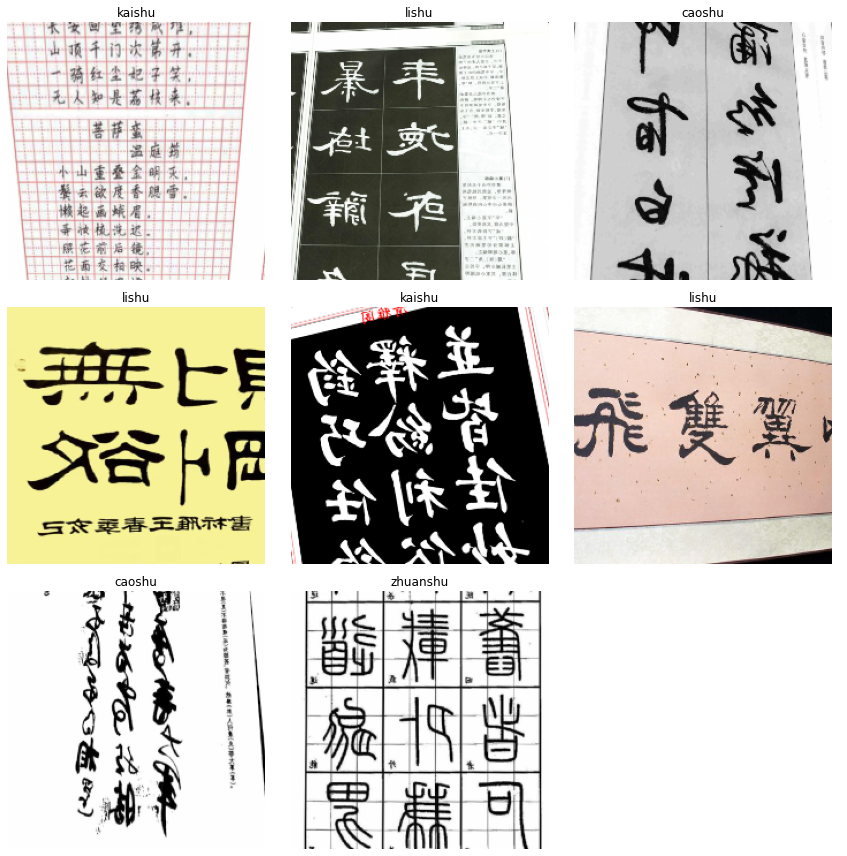

In [24]:
# Display some images
db.show_batch()

## Retraining the Model
Now, we can apply the same training steps as above but using the cleaned data. We are also going to use the saved model so we don’t need to train the weights from scratch.

In [25]:
# Replacing the data
learn.data = db

In [40]:
# Freeze the layers
learn.freeze()
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.538376,0.561337,0.785978,00:53
1,0.663303,0.457006,0.852399,00:53
2,0.479915,0.285449,0.904059,00:53
3,0.435590,0.235354,0.915129,00:53


In [41]:
# Unfreeze the layers and find LR
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-05


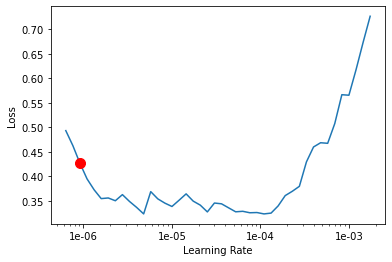

In [42]:
# Plot the LR
learn.recorder.plot(suggestion=True)

In [29]:
# Get the corresponding LR
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

1.3182567385564074e-06

In [43]:
# Train the model for another 4 epochs
learn.fit_one_cycle(4, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.428563,0.235304,0.922509,00:54
1,0.398285,0.289792,0.892989,00:54
2,0.422449,0.230904,0.926199,00:54
3,0.436341,0.261377,0.915129,00:54


With only very few lines of code and very minimum efforts for data collection, we managed to achieve an accuracy of 92%. I believe with more and better-quality data, we can achieve a state-of-the-art result.

## Interpreting the Results
Finally, we can use fast.ai’s `ClassificationInterpretation` class to interpret our results. To do this, we need to pass our model to the `from_learner` method.

In [44]:
# Create an interpreter instance
interp = ClassificationInterpretation.from_learner(learn)

Then, we can use the `plot_confusion_matrix` method to see where our model seems to be confused.

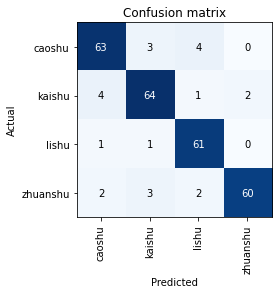

In [45]:
# Plot the confusion matrix
interp.plot_confusion_matrix()

From the confusion matrix, we can see that our model does pretty well in classifying the ‘zhuanshu’ style. This is probably due to its unique stroke arrangements. To wrap up, let’s also plot some predictions by calling the `learn.show_results` method.

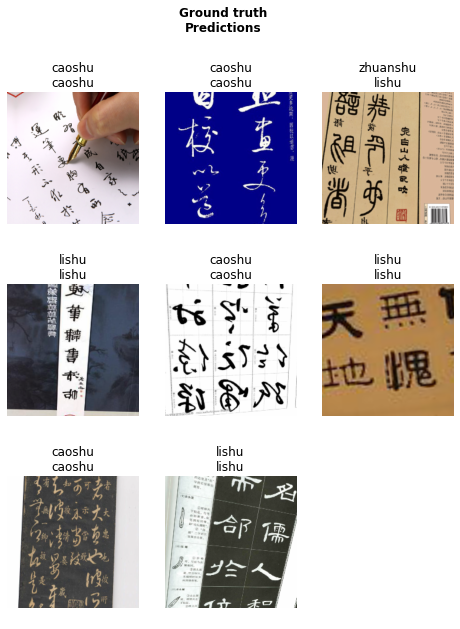

In [46]:
# Show some predictions
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,10))